# KLRfome Quickstart Tutorial

This notebook demonstrates the basic workflow for using KLRfome (Kernel Logistic Regression on Focal Mean Embeddings) for geographic distribution regression.

## What is KLRfome?

KLRfome solves a **Distribution Regression** problem for geographic/spatial prediction. Unlike traditional regression that maps single observations to outcomes, KLRfome:

1. Represents each site as a **distribution** of environmental feature vectors
2. Computes similarity between distributions using **mean embeddings in RKHS**
3. Fits **Kernel Logistic Regression** on the similarity matrix
4. Predicts using **focal windows** that compute similarity between landscape neighborhoods and training data

This approach is ideal for archaeological site prediction, habitat modeling, and other spatial problems where sites are areas, not points.


## Setup

First, let's import the necessary packages and set random seeds for reproducibility.


In [16]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_bounds
import geopandas as gpd
from shapely.geometry import Point

from klrfome import KLRfome, RasterStack
from klrfome.data.simulation import sim_trend, rescale_sim_raster, nlm_gaussianfield
from klrfome.visualization import plot_predictions

# Set random seeds for reproducibility
SEED =  1322
np.random.seed(SEED)


## Step 1: Generate Simulated Data

We'll create a simulated raster stack with **correlated** site locations. This approach creates site-likely and site-unlikely environmental conditions, then uses a trend surface to ensure sites are placed in favorable locations. This creates realistic correlations that allow the model to learn meaningful patterns.

**Note**: In practice, you would load real rasters and site shapefiles.


In [17]:
# Create REALISTIC simulated data with moderate (not extreme) correlations
# This creates data where sites have preferences but there's significant overlap with background
# Adjust parameters below to control difficulty level

cols = 100
rows = 100
n_sites = 20
autocorr_range = 15  # Spatial autocorrelation range

# =============================================================================
# DIFFICULTY SETTINGS (adjust these to control how "easy" or "hard" the data is)
# =============================================================================
mix_strength = 0.3      # 0.0 = no signal, 1.0 = perfect signal (realistic: 0.2-0.5)
trend_power = 1.0       # 1.0 = linear decay, 2.0+ = concentrated (realistic: 1.0)
favor_threshold = 0.5   # Sites in bottom X% of favorability (realistic: 0.4-0.6)
noise_level = 0.15      # Random noise to add (realistic: 0.1-0.2)
# =============================================================================

# Step 1: Create site-likely rasters (conditions favorable for sites)
# Means are CLOSER together for more realistic overlap
s_var1r = nlm_gaussianfield(cols, rows, autocorr_range=autocorr_range, seed=SEED)
s_var1 = rescale_sim_raster(s_var1r, 60, 15)   # Mean=60, SD=15 (closer to background)
s_var2 = rescale_sim_raster(s_var1r, 4, 2)     # Mean=4, SD=2
s_var3 = rescale_sim_raster(s_var1r, 6, 1.5)   # Mean=6, SD=1.5

# Step 2: Create site-unlikely rasters (background conditions)
# Means are CLOSER to site-likely for more realistic overlap
b_var1r = nlm_gaussianfield(cols, rows, autocorr_range=autocorr_range, seed=SEED + 1000)
b_var1 = rescale_sim_raster(b_var1r, 80, 15)   # Mean=80, SD=15 (closer to sites)
b_var2 = rescale_sim_raster(b_var1r, 5, 2)     # Mean=5, SD=2
b_var3 = rescale_sim_raster(b_var1r, 8, 1.5)   # Mean=8, SD=1.5

# Step 3: Place sites in favorable areas
favorability_surface = s_var1r
trend_result = sim_trend(
    cols, rows, 
    n=n_sites, 
    size=6, 
    seed=SEED,
    favorable_surface=favorability_surface,
    favor_threshold=favor_threshold
)
trend = trend_result['trend']
site_coords_pixels = trend_result['coords']

# Step 4: Apply trend power (controls how concentrated the effect is)
trend = np.power(trend, trend_power)
inv_trend = 1 - trend

# Step 5: Combine rasters with controlled mixing
# Lower mix_strength = more overlap between site and background conditions
var1 = (s_var1 * (trend * mix_strength + (1 - mix_strength) * 0.5)) + (b_var1 * (inv_trend * mix_strength + (1 - mix_strength) * 0.5))
var2 = (s_var2 * (trend * mix_strength + (1 - mix_strength) * 0.5)) + (b_var2 * (inv_trend * mix_strength + (1 - mix_strength) * 0.5))
var3 = (s_var3 * (trend * mix_strength + (1 - mix_strength) * 0.5)) + (b_var3 * (inv_trend * mix_strength + (1 - mix_strength) * 0.5))

# Step 6: Add random noise to make data more realistic
np.random.seed(SEED)
var1 = var1 + np.random.normal(0, noise_level * np.std(var1), var1.shape)
var2 = var2 + np.random.normal(0, noise_level * np.std(var2), var2.shape)
var3 = var3 + np.random.normal(0, noise_level * np.std(var3), var3.shape)

# Step 6: Create RasterStack from combined rasters
# Convert to JAX arrays for compatibility
data = jnp.array([var1, var2, var3])
transform = from_bounds(0, 0, 1, 1, cols, rows)
band_names = ['var1', 'var2', 'var3']

raster_stack = RasterStack(
    data=data,
    transform=transform,
    crs="EPSG:4326",
    band_names=band_names
)

print(f"Raster shape: {raster_stack.data.shape}")
print(f"Band names: {raster_stack.band_names}")
print(f"CRS: {raster_stack.crs}")

# Step 7: Convert pixel coordinates to geographic coordinates for sites
site_points = []
for coord in site_coords_pixels:
    # sim_trend returns (col, row), transform.xy expects (row, col)
    x, y = rasterio.transform.xy(transform, coord[1], coord[0])
    site_points.append(Point(x, y))

sites_gdf = gpd.GeoDataFrame(
    geometry=site_points,
    crs=raster_stack.crs
)

print(f"\nCreated {len(sites_gdf)} site locations with REALISTIC correlations:")
print(f"  • mix_strength={mix_strength} (lower = harder, 0.3 is moderately challenging)")
print(f"  • trend_power={trend_power} (1.0 = gradual, 2.0+ = concentrated)")
print(f"  • favor_threshold={favor_threshold} (sites in bottom {int(favor_threshold*100)}% of favorability)")
print(f"  • noise_level={noise_level} (random noise added)")
print(f"  Adjust DIFFICULTY SETTINGS above to make data easier/harder to predict")


Raster shape: (3, 100, 100)
Band names: ['var1', 'var2', 'var3']
CRS: EPSG:4326

Created 20 site locations with REALISTIC correlations:
  • mix_strength=0.3 (lower = harder, 0.3 is moderately challenging)
  • trend_power=1.0 (1.0 = gradual, 2.0+ = concentrated)
  • favor_threshold=0.5 (sites in bottom 50% of favorability)
  • noise_level=0.15 (random noise added)
  Adjust DIFFICULTY SETTINGS above to make data easier/harder to predict


## Step 2: Initialize the Model

Create a KLRfome model with default parameters. Key hyperparameters:
- `sigma`: RBF kernel bandwidth (controls similarity scale)
- `lambda_reg`: L2 regularization strength
- `n_rff_features`: Number of random Fourier features (0 for exact kernel, >0 for approximation)
- `window_size`: Size of focal window for prediction (e.g., 3 = 3×3 window)


In [18]:
# Initialize model
# NOTE: sigma=0.5 works well with scaled (z-score normalized) data
# RFF (n_rff_features>0) is faster for large datasets while maintaining accuracy
model = KLRfome(
    sigma=0.5,              # Kernel bandwidth (0.5 works well for scaled data)
    lambda_reg=0.1,         # Regularization strength
    n_rff_features=512,     # Use RFF approximation (faster, set 0 for exact kernel)
    window_size=5,          # 5×5 focal window
    seed=SEED
)

print("Model initialized with:")
print(f"  Sigma: {model.sigma}")
print(f"  Lambda: {model.lambda_reg}")
print(f"  RFF features: {model.n_rff_features}")
print(f"  Window size: {model.window_size}")


Model initialized with:
  Sigma: 0.5
  Lambda: 0.1
  RFF features: 512
  Window size: 5


## Step 3: Prepare Training Data

The `prepare_data()` method extracts samples from the raster at site locations and generates background samples. Each location becomes a "bag" of samples (a distribution).


In [19]:
# Prepare training data
raw_training_data = model.prepare_data(
    raster_stack=raster_stack,
    sites=sites_gdf,
    n_background=50,              # Number of background sample locations
    samples_per_location=20,       # Samples per site/background location
    site_buffer=0.01,             # Buffer around site points (in CRS units)
    background_exclusion_buffer=0.02  # Exclude background near sites
)

# CRITICAL: Scale the data (z-score normalization) - this is essential for good results!
# The kernel (especially with sigma=0.5) expects standardized features
from klrfome.data.formats import SampleCollection, TrainingData

# Compute scaling parameters from all samples
all_samples = np.vstack([np.array(c.samples) for c in raw_training_data.collections])
means = np.mean(all_samples, axis=0)
sds = np.std(all_samples, axis=0)
sds = np.where(sds < 1e-10, 1.0, sds)  # Avoid division by zero

print(f"Scaling parameters:")
print(f"  Means: {means}")
print(f"  Stds:  {sds}")

# Scale all collections
def scale_collection(coll):
    samples_array = jnp.array(coll.samples) if not isinstance(coll.samples, jnp.ndarray) else coll.samples
    scaled_samples = (samples_array - jnp.array(means)) / jnp.array(sds)
    return SampleCollection(
        samples=scaled_samples,
        label=coll.label,
        id=coll.id,
        metadata=coll.metadata
    )

scaled_collections = [scale_collection(c) for c in raw_training_data.collections]
training_data = TrainingData(
    collections=scaled_collections,
    feature_names=raw_training_data.feature_names,
    crs=raw_training_data.crs
)

print(f"\nTraining data prepared and scaled:")
print(f"  Total locations: {training_data.n_locations}")
print(f"  Sites: {training_data.n_sites}")
print(f"  Background: {training_data.n_background}")
print(f"  Features: {training_data.feature_names}")

# Show sample collection info
if len(training_data.collections) > 0:
    first_coll = training_data.collections[0]
    print(f"\nFirst collection (scaled):")
    print(f"  ID: {first_coll.id}")
    print(f"  Label: {first_coll.label} (1=site, 0=background)")
    print(f"  Samples: {first_coll.n_samples}")
    print(f"  Features: {first_coll.n_features}")
    print(f"  Sample values (first row): {first_coll.samples[0]}")


Scaling parameters:
  Means: [67.08499    4.2361436  6.7507944]
  Stds:  [11.302769   1.5157565  1.1529161]

Training data prepared and scaled:
  Total locations: 70
  Sites: 20
  Background: 50
  Features: ['var1', 'var2', 'var3']

First collection (scaled):
  ID: location_0
  Label: 1 (1=site, 0=background)
  Samples: 20
  Features: 3
  Sample values (first row): [-0.63018143 -0.46732548 -0.51977336]


In [20]:
# # Prepare training data
# training_data = model.prepare_data(
#     raster_stack=raster_stack,
#     sites=sites_gdf,
#     n_background=50,              # Number of background sample locations
#     samples_per_location=20,       # Samples per site/background location
#     site_buffer=0.01,             # Buffer around site points (in CRS units)
#     background_exclusion_buffer=0.02  # Exclude background near sites
# )

# print(f"Training data prepared:")
# print(f"  Total locations: {training_data.n_locations}")
# print(f"  Sites: {training_data.n_sites}")
# print(f"  Background: {training_data.n_background}")
# print(f"  Features: {training_data.feature_names}")

# # Show sample collection info
# if len(training_data.collections) > 0:
#     first_coll = training_data.collections[0]
#     print(f"\nFirst collection:")
#     print(f"  ID: {first_coll.id}")
#     print(f"  Label: {first_coll.label} (1=site, 0=background)")
#     print(f"  Samples: {first_coll.n_samples}")
#     print(f"  Features: {first_coll.n_features}")


## Step 4: Fit the Model

Fit the KLR model on the similarity matrix between all training locations.


In [21]:
# Fit the model
model.fit(training_data)

# Check convergence
if model._fit_result.converged:
    print(f"✓ Model converged in {model._fit_result.n_iterations} iterations")
    print(f"  Final loss: {model._fit_result.final_loss:.6f}")
else:
    print(f"⚠ Model did not converge after {model._fit_result.n_iterations} iterations")

# Check similarity matrix
print(f"\nSimilarity matrix shape: {model._similarity_matrix.shape}")
print(f"Similarity range: [{jnp.min(model._similarity_matrix):.3f}, {jnp.max(model._similarity_matrix):.3f}]")


✓ Model converged in 4 iterations
  Final loss: 4.610876

Similarity matrix shape: (70, 70)
Similarity range: [-0.117, 1.071]


## Step 5: Predict Across the Landscape

Generate predictions using focal windows. Each pixel's prediction is based on the similarity between its neighborhood and the training data.

**CRITICAL**: The raster stack must be scaled using the same parameters (means, stds) used to scale the training data. This ensures the kernel comparisons are consistent.


In [22]:
# CRITICAL: Scale the raster stack using the SAME parameters used for training data!
# The model was trained on scaled data, so predictions must use scaled rasters
print("Scaling raster stack for prediction...")
print(f"  Using means: {means}")
print(f"  Using stds:  {sds}")

# Scale each band of the raster stack
scaled_data = np.zeros_like(raster_stack.data)
for i in range(raster_stack.n_bands):
    scaled_data[i] = (raster_stack.data[i] - means[i]) / sds[i]

# Create scaled RasterStack
scaled_raster_stack = RasterStack(
    data=scaled_data,
    transform=raster_stack.transform,
    crs=raster_stack.crs,
    band_names=raster_stack.band_names
)

print(f"  Original raster range (band 0): [{np.min(raster_stack.data[0]):.2f}, {np.max(raster_stack.data[0]):.2f}]")
print(f"  Scaled raster range (band 0): [{np.min(scaled_data[0]):.2f}, {np.max(scaled_data[0]):.2f}]")

# Generate predictions using SCALED raster stack
predictions = model.predict(
    raster_stack=scaled_raster_stack,  # Use scaled raster!
    batch_size=500,        # Process 500 windows at a time
    show_progress=True
)

print(f"\nPrediction shape: {predictions.shape}")
print(f"Prediction range: [{jnp.min(predictions):.3f}, {jnp.max(predictions):.3f}]")
print(f"Mean probability: {jnp.mean(predictions):.3f}")


Scaling raster stack for prediction...
  Using means: [67.08499    4.2361436  6.7507944]
  Using stds:  [11.302769   1.5157565  1.1529161]
  Original raster range (band 0): [31.54, 107.99]
  Scaled raster range (band 0): [-3.15, 3.62]


Predicting: 100%|██████████| 20/20 [00:00<00:00, 73.41it/s] 



Prediction shape: (100, 100)
Prediction range: [0.052, 0.784]
Mean probability: 0.294


## Step 6: Visualize Results

Plot the prediction map with training sites overlaid.


## Step 7: Model Evaluation

Evaluate the model performance using metrics similar to the R package. We'll extract predictions at site locations and background locations, then compute comprehensive metrics at multiple thresholds.


In [23]:
# Extract predictions at site locations and background locations
from klrfome.utils.validation import CM_quads, metrics, compute_roc_auc
from klrfome.visualization import plot_roc_curve
import pandas as pd

# Set random seed for reproducibility
np.random.seed(SEED)

# Extract predictions at site locations (using buffer around points)
transform = raster_stack.transform
site_predictions = []
for idx, row in sites_gdf.iterrows():
    geom = row.geometry
    # rowcol returns (row, col) - order matters!
    row_idx, col = rasterio.transform.rowcol(transform, geom.x, geom.y)
    if 0 <= row_idx < predictions.shape[0] and 0 <= col < predictions.shape[1]:
        # Extract from a small window around the site
        window_size = 2
        row_start = max(0, row_idx - window_size)
        row_end = min(predictions.shape[0], row_idx + window_size + 1)
        col_start = max(0, col - window_size)
        col_end = min(predictions.shape[1], col + window_size + 1)
        window_preds = predictions[row_start:row_end, col_start:col_end]
        site_predictions.extend(window_preds.flatten().tolist())

# Sample background predictions (random locations)
n_background_samples = 500
background_predictions = []
for _ in range(n_background_samples):
    row = np.random.randint(0, predictions.shape[0])
    col = np.random.randint(0, predictions.shape[1])
    background_predictions.append(float(predictions[row, col]))

# Create evaluation dataframe
model_pred = pd.DataFrame({
    'pred': site_predictions + background_predictions,
    'presence': [1] * len(site_predictions) + [0] * len(background_predictions)
})

print(f"Evaluation data prepared:")
print(f"  Site samples: {len(site_predictions)}")
print(f"  Background samples: {len(background_predictions)}")
print(f"  Total samples: {len(model_pred)}")


Evaluation data prepared:
  Site samples: 500
  Background samples: 500
  Total samples: 1000


In [24]:
# Compute confusion matrix metrics at multiple thresholds
thresholds = np.arange(0, 1.1, 0.1)
kstats = CM_quads(model_pred['pred'], model_pred['presence'], threshold=thresholds)

# Compute comprehensive metrics at each threshold
test_metrics = []
for _, row in kstats.iterrows():
    TP = int(row['TP'])
    TN = int(row['TN'])
    FP = int(row['FP'])
    FN = int(row['FN'])
    
    # Compute metrics
    m = metrics(TP, TN, FP, FN)
    
    # Add threshold and basic metrics
    result = {
        'Threshold': row['Threshold'],
        'TP': TP,
        'FP': FP,
        'TN': TN,
        'FN': FN,
        'Sensitivity': m.get('Sensitivity', 0.0),
        'FPR': m.get('FPR', 0.0),
        'FNR': m.get('FNR', 0.0),
        'YoudensJ': m.get('Informedness', 0.0),  # Youden's J = Informedness
        'KG': m.get('KG', 0.0),  # Kvamme Gain
        'Precision': m.get('Precision', 0.0),
        'Specificity': m.get('Specificity', 0.0),
    }
    test_metrics.append(result)

# Compute AUC (same for all thresholds)
auc_value = compute_roc_auc(model_pred['pred'], model_pred['presence'])
for result in test_metrics:
    result['AUC'] = auc_value

# Create metrics dataframe
test_area_metrics = pd.DataFrame(test_metrics)

# Display metrics table
print("\nModel Evaluation Metrics at Different Thresholds:")
print("=" * 100)
display(test_area_metrics.round(3))



Model Evaluation Metrics at Different Thresholds:


/Users/mattharris/Documents/Python_local/KLRFome_JAX/klrfome/utils/validation.py:193: RuntimeWarning: invalid value encountered in sqrt
  'AFK': np.sqrt(Sensitivity * safe_divide((Sensitivity - (1 - Specificity)), ((TN + FP) / n), default=0.0)) if Sensitivity > 0 and (TN + FP) > 0 and n > 0 else 0.0,


,Threshold,TP,FP,TN,FN,Sensitivity,FPR,FNR,YoudensJ,KG,Precision,Specificity,AUC
0,0.0,500,500,0,0,1.000,1.000,0.000,0.000,0.000,0.500,0.000,0.743
1,0.1,500,479,21,0,1.000,0.958,0.000,0.042,0.042,0.511,0.042,0.743
2,0.2,478,382,118,22,0.956,0.764,0.044,0.192,0.201,0.556,0.236,0.743
3,0.3,415,206,294,85,0.830,0.412,0.170,0.418,0.504,0.668,0.588,0.743
4,0.4,223,102,398,277,0.446,0.204,0.554,0.242,0.543,0.686,0.796,0.743
5,0.5,109,49,451,391,0.218,0.098,0.782,0.120,0.550,0.690,0.902,0.743
6,0.6,43,21,479,457,0.086,0.042,0.914,0.044,0.512,0.672,0.958,0.743
7,0.7,3,6,494,497,0.006,0.012,0.994,-0.006,-1.000,0.333,0.988,0.743
8,0.8,0,0,500,500,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.743
9,0.9,0,0,500,500,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.743


In [25]:
# Find optimal threshold (maximizing Youden's J)
optimal_idx = test_area_metrics['YoudensJ'].idxmax()
optimal_threshold = test_area_metrics.loc[optimal_idx, 'Threshold']
optimal_metrics = test_area_metrics.loc[optimal_idx]

print(f"\nOptimal Threshold (maximizing Youden's J): {optimal_threshold:.1f}")
print(f"  Sensitivity: {optimal_metrics['Sensitivity']:.3f}")
print(f"  FPR: {optimal_metrics['FPR']:.3f}")
print(f"  Youden's J: {optimal_metrics['YoudensJ']:.3f}")
print(f"  Kvamme Gain: {optimal_metrics['KG']:.3f}")
print(f"  AUC: {optimal_metrics['AUC']:.3f}")



Optimal Threshold (maximizing Youden's J): 0.3
  Sensitivity: 0.830
  FPR: 0.412
  Youden's J: 0.418
  Kvamme Gain: 0.504
  AUC: 0.743


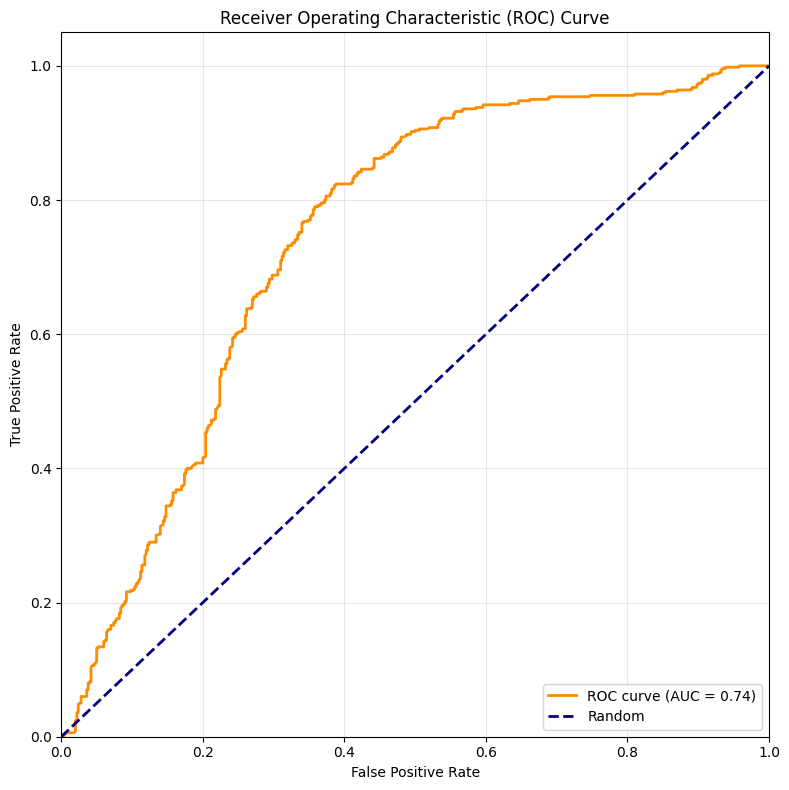

In [26]:
# Plot 1: ROC Curve
fig, ax = plot_roc_curve(model_pred['pred'], model_pred['presence'], figsize=(8, 8))
plt.show()


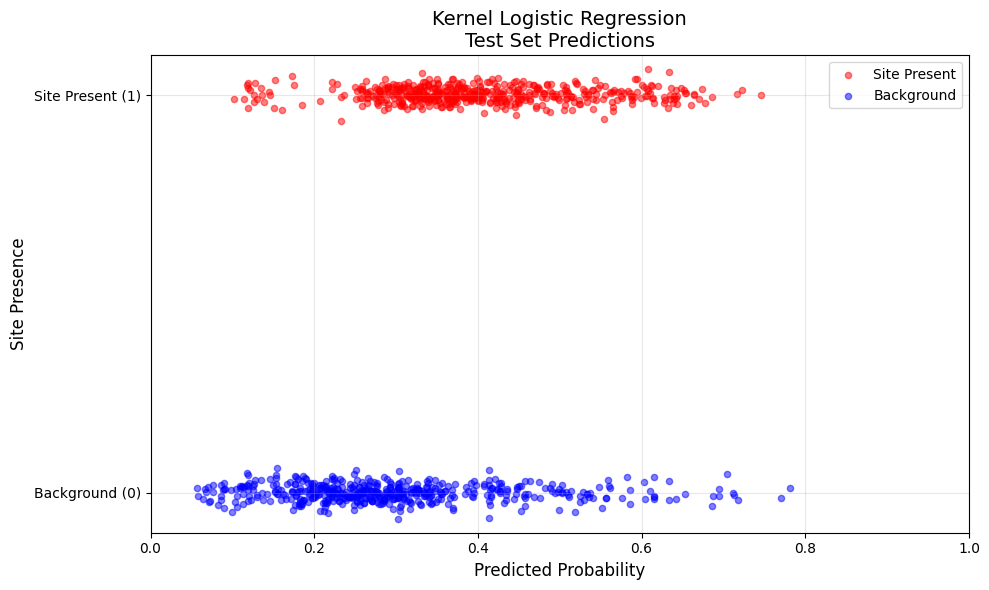

In [27]:
# Plot 2: Prediction Distribution (similar to R version)
fig, ax = plt.subplots(figsize=(10, 6))

# Separate predictions by presence/absence
site_preds = model_pred[model_pred['presence'] == 1]['pred']
bg_preds = model_pred[model_pred['presence'] == 0]['pred']

# Create jitter plot (set seed for reproducible jitter)
np.random.seed(SEED)
y_sites = np.ones(len(site_preds)) + np.random.normal(0, 0.02, len(site_preds))
y_bg = np.zeros(len(bg_preds)) + np.random.normal(0, 0.02, len(bg_preds))

ax.scatter(site_preds, y_sites, alpha=0.5, label='Site Present', color='red', s=20)
ax.scatter(bg_preds, y_bg, alpha=0.5, label='Background', color='blue', s=20)

ax.set_xlabel('Predicted Probability', fontsize=12)
ax.set_ylabel('Site Presence', fontsize=12)
ax.set_title('Kernel Logistic Regression\nTest Set Predictions', fontsize=14)
ax.set_ylim(-0.1, 1.1)
ax.set_xlim(0, 1)
ax.set_yticks([0, 1])
ax.set_yticklabels(['Background (0)', 'Site Present (1)'])
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


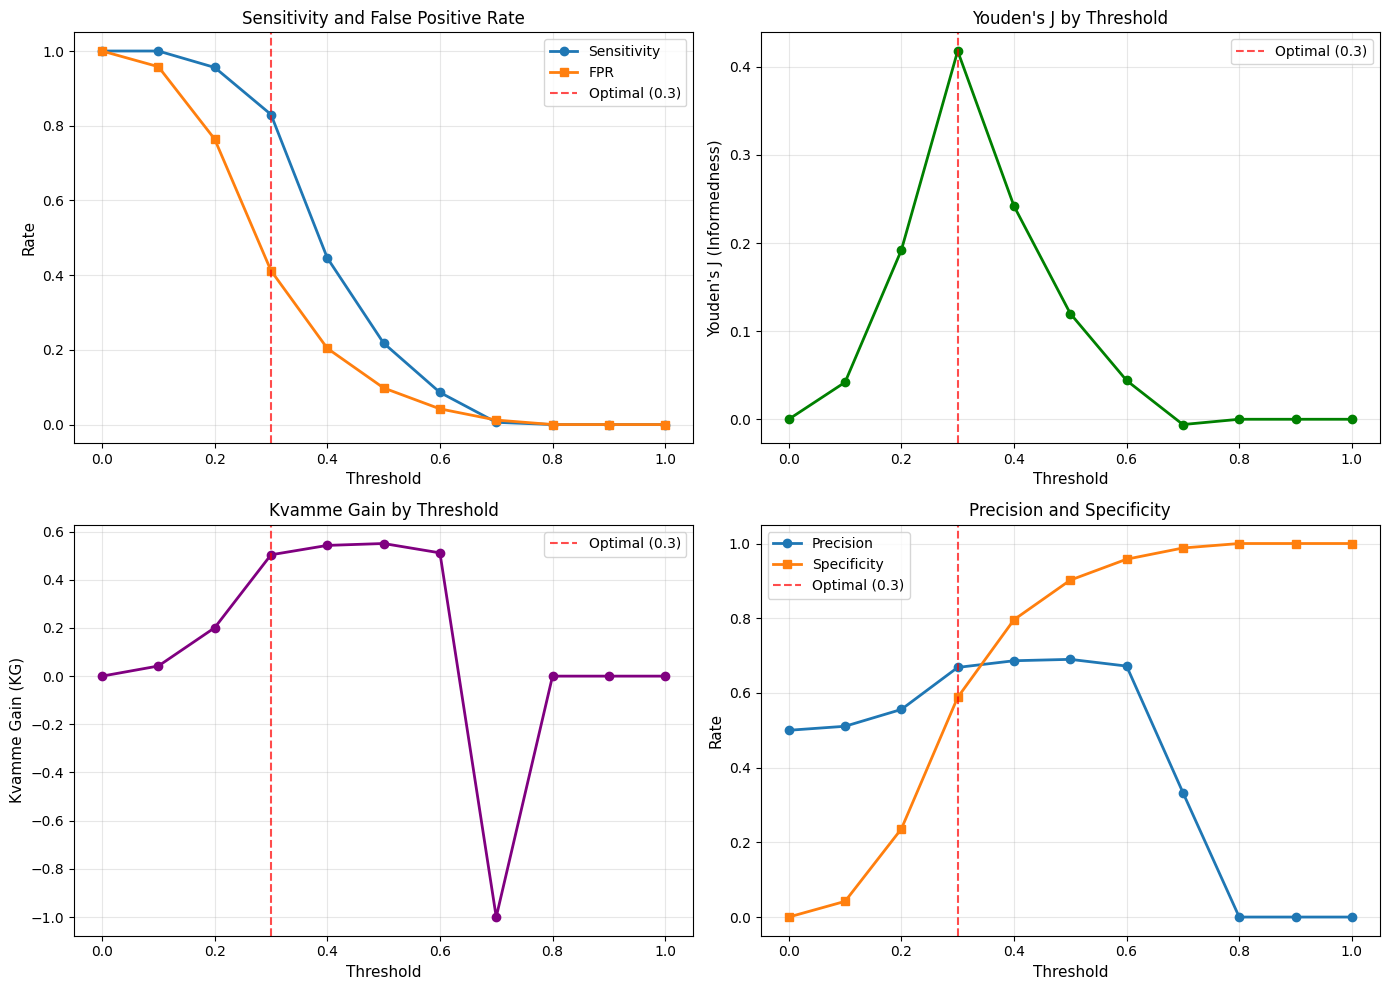

In [28]:
# Plot 3: Metrics vs Threshold
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sensitivity and FPR
ax = axes[0, 0]
ax.plot(test_area_metrics['Threshold'], test_area_metrics['Sensitivity'], 
        'o-', label='Sensitivity', linewidth=2, markersize=6)
ax.plot(test_area_metrics['Threshold'], test_area_metrics['FPR'], 
        's-', label='FPR', linewidth=2, markersize=6)
ax.axvline(optimal_threshold, color='red', linestyle='--', alpha=0.7, label=f'Optimal ({optimal_threshold:.1f})')
ax.set_xlabel('Threshold', fontsize=11)
ax.set_ylabel('Rate', fontsize=11)
ax.set_title('Sensitivity and False Positive Rate', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# Youden's J
ax = axes[0, 1]
ax.plot(test_area_metrics['Threshold'], test_area_metrics['YoudensJ'], 
        'o-', color='green', linewidth=2, markersize=6)
ax.axvline(optimal_threshold, color='red', linestyle='--', alpha=0.7, label=f'Optimal ({optimal_threshold:.1f})')
ax.set_xlabel('Threshold', fontsize=11)
ax.set_ylabel("Youden's J (Informedness)", fontsize=11)
ax.set_title("Youden's J by Threshold", fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# Kvamme Gain
ax = axes[1, 0]
ax.plot(test_area_metrics['Threshold'], test_area_metrics['KG'], 
        'o-', color='purple', linewidth=2, markersize=6)
ax.axvline(optimal_threshold, color='red', linestyle='--', alpha=0.7, label=f'Optimal ({optimal_threshold:.1f})')
ax.set_xlabel('Threshold', fontsize=11)
ax.set_ylabel('Kvamme Gain (KG)', fontsize=11)
ax.set_title('Kvamme Gain by Threshold', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# Precision and Specificity
ax = axes[1, 1]
ax.plot(test_area_metrics['Threshold'], test_area_metrics['Precision'], 
        'o-', label='Precision', linewidth=2, markersize=6)
ax.plot(test_area_metrics['Threshold'], test_area_metrics['Specificity'], 
        's-', label='Specificity', linewidth=2, markersize=6)
ax.axvline(optimal_threshold, color='red', linestyle='--', alpha=0.7, label=f'Optimal ({optimal_threshold:.1f})')
ax.set_xlabel('Threshold', fontsize=11)
ax.set_ylabel('Rate', fontsize=11)
ax.set_title('Precision and Specificity', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


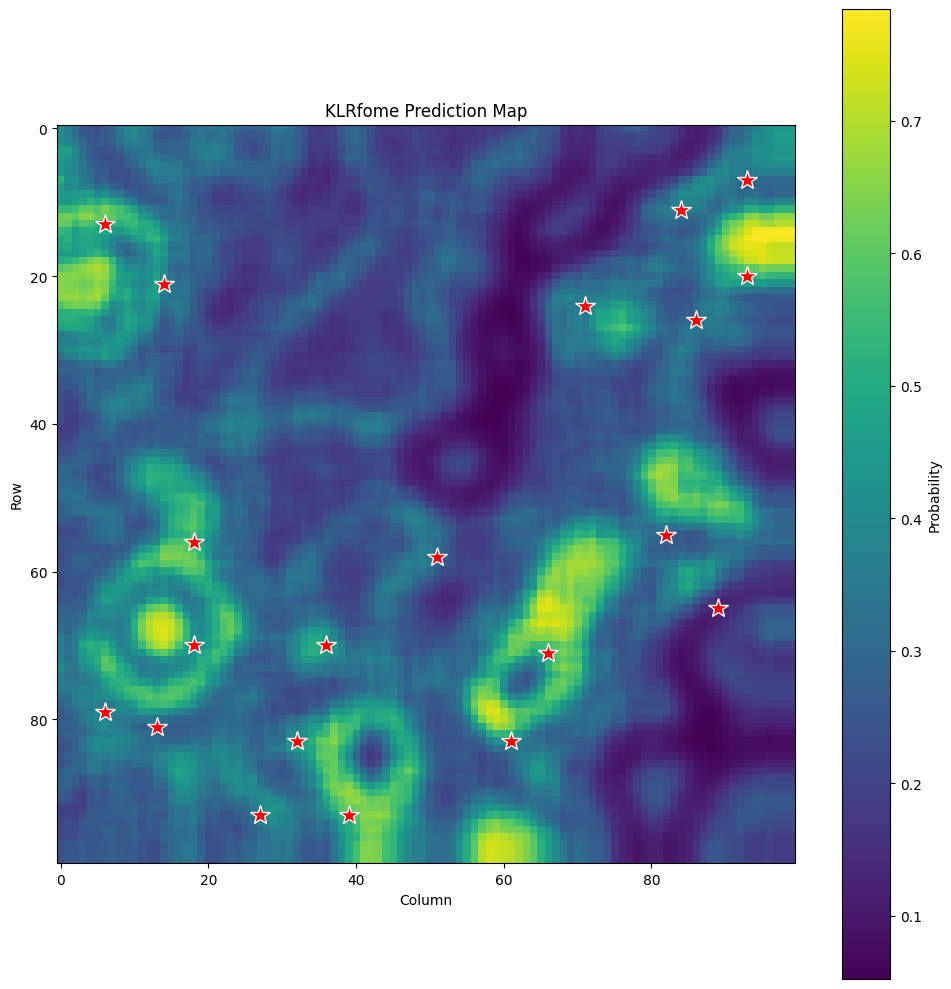

In [29]:
# Plot predictions
fig, ax = plot_predictions(
    predictions,
    sites=sites_gdf,
    figsize=(10, 10),
    cmap='viridis',
    title='KLRfome Prediction Map'
)

# Overlay site locations
# Convert to pixel coordinates for plotting
transform = raster_stack.transform
for idx, row in sites_gdf.iterrows():
    geom = row.geometry
    # rowcol returns (row, col) - order matters!
    row_idx, col = rasterio.transform.rowcol(transform, geom.x, geom.y)
    if 0 <= row_idx < predictions.shape[0] and 0 <= col < predictions.shape[1]:
        ax.plot(col, row_idx, 'r*', markersize=15, markeredgecolor='white', markeredgewidth=1)

plt.tight_layout()
plt.show()


## Step 7: Save Results

Save the prediction as a GeoTIFF for use in GIS software.


In [30]:
# Save prediction (commented out to avoid creating files during tutorial)
# model.save_prediction(
#     "prediction_output.tif",
#     predictions,
#     reference_raster=raster_stack
# )
# print("Prediction saved to prediction_output.tif")

print("To save predictions, uncomment the code above.")


To save predictions, uncomment the code above.


## Summary

This tutorial demonstrated the basic KLRfome workflow:

1. **Generate/Load Data**: Create or load raster stacks and site locations
2. **Initialize Model**: Set hyperparameters (sigma, lambda, window size)
3. **Prepare Training Data**: Extract samples at sites and background locations
4. **Fit Model**: Build similarity matrix and fit KLR
5. **Predict**: Generate probability map using focal windows
6. **Visualize**: Plot results with site locations
7. **Save**: Export as GeoTIFF for GIS

### Next Steps

- **Notebook 02**: Working with real rasters and shapefiles
- **Notebook 03**: Hyperparameter tuning with cross-validation
- **Notebook 04**: Advanced kernel options and performance comparison
